# Am I travelling less? 

In a middle of a playful spat with the spouse, I mentioned how I - an erstwhile, avid traveller - had been travelling less ever since I met him. True to nature, he vehemently disagreed so I decided to pull out my Google Timeline data and prove him wrong with stats. 

I like to keep the location on my phone turned on - another thing we disagree about but that is a matter for another day. For now, I headed on over to Google site and downloaded the timeline data. It turned out to be a huge file (0.5GB) for only 4 years worth of data, which did give me slight pause about my location tracking preferences but I'll worry about that later :P    

In [1]:
# Importing the necessary packages and settings 
import pandas as pd
import numpy as np
import re
import datetime
import itertools
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt 

import pymc3 as pm
import theano.tensor as tt

import seaborn as sns
from IPython.core.pylabtools import figsize

from geopy.geocoders import Nominatim 
from geopy.extra.rate_limiter import RateLimiter

sns.set() 
pd.set_option('display.max_colwidth', -1) 

geolocator = Nominatim(user_agent="test")

In [3]:
# Saving the latitude, longitude and timestamp data into a dataframe 
# I haven't included it but I had to use file operations to read the giant file 
# that I downloaded from Google and retrieve just the lines I needed and save to a separate file 

timestampList = []
latList = []
longList = []

with open("/data/end_file.txt", 'r') as openfileobject:
    lines = openfileobject.readlines()
    timestamplines = lines[0::3]
    for line in timestamplines:
        timestampMs = re.search(r':\s\"(.*?)\",\n$', line, re.M)
        if timestampMs is not None:
            timestampList.append(timestampMs.groups()[0])
    latlines = lines[1::3]
    for line in latlines:
        latitudeE7 = re.search(r':\s(.*?),\n$', line, re.M)
        if latitudeE7 is not None: 
            latList.append(latitudeE7.groups()[0])
    longlines = lines[2::3]
    for line in longlines:
        longitudeE7 = re.search(r':\s(.*?),\n$', line, re.M)
        if longitudeE7 is not None:
            longList.append(longitudeE7.groups()[0])

In [8]:
# This is the part where I used geopy to give me the address/location for all the lat-long coordinates that I have 
# With my data, it took roughly 3 hours to run
# I later saved this file to a pickle file for easy access 

# # location = geolocator.reverse("28.4433025,77.0752722") 
# from tqdm import tqdm
# tqdm.pandas() 
# geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)
# place_list['location'] = place_list['str'].progress_apply(geocode) 

# place_list.to_pickle('place_list.pkl')

In [4]:
place_list = pd.read_pickle('place_list.pkl')

In [5]:
# df contains all the latitude, longitude and the timestamp data 
# below are some operations to retrieve the year, month etc. from the data 

df = pd.DataFrame()
df['ts'] = timestampList
df['lat'] = latList
df['long'] = longList

df['lat1'] = df['lat'].apply(lambda x: pd.to_numeric(x)/10000000)
df['long1'] = df['long'].apply(lambda x: pd.to_numeric(x)/10000000) 

df['lat_uni'] = df['lat'].apply(lambda x: np.floor(pd.to_numeric(x)/100000))
df['long_uni'] = df['long'].apply(lambda x: np.floor(pd.to_numeric(x)/100000))

df['ts1'] = df['ts'].apply(lambda x: datetime.datetime.fromtimestamp(pd.to_numeric(x)/1000.0))
df['year'] = df['ts1'].apply(lambda x: x.year)
df['qtr'] = df['ts1'].apply(lambda x: x.quarter)
df['month'] = df['ts1'].apply(lambda x: x.month) 

df['str'] = df['lat1'].apply(str) + ',' + df['long1'].apply(str) 

In [6]:
# The API didn't return the locations for a few of my coordinates so I need to drop the None entries  
place_list.dropna(subset= ['location'], inplace=True) 
place_list['str_location'] = place_list['location'].apply(lambda x: x[0]) 
place_list.dropna(subset= ['str_location'], inplace=True)

In [8]:
# Splitting the location to a list so I can access the separate elements 
place_list['address'] = place_list['str_location'].str.split(',').tolist() 

In [9]:
# The city is in the 5th from the last element in the list 
# In the few special cases where there are less than 5 elements, I'm considering the first element to be the city
place_list['city'] = place_list['address'].apply(lambda x: x[-5] if (len(x)>=5) else x[0]) 
place_list['country'] = place_list['address'].apply(lambda x: x[-1])

In [10]:
# The final_df combine my timestamps with the actual cities and countries so I can count 
# the unique places that I've been to 

final_df = pd.merge(df, place_list[['lat_uni', 'long_uni', 'city', 'country']], 
              how='left', on=['lat_uni', 'long_uni'])

In [11]:
# I'm creating a summary DF which will store the unique cities that I've been to by month and year 
df_summary = final_df.drop_duplicates(subset=['year', 'month', 'city']).groupby(['year','month']).size().reset_index()
df_summary['yr_mnth'] = df_summary['year'].apply(str) + "-" + df_summary['month'].apply(str)



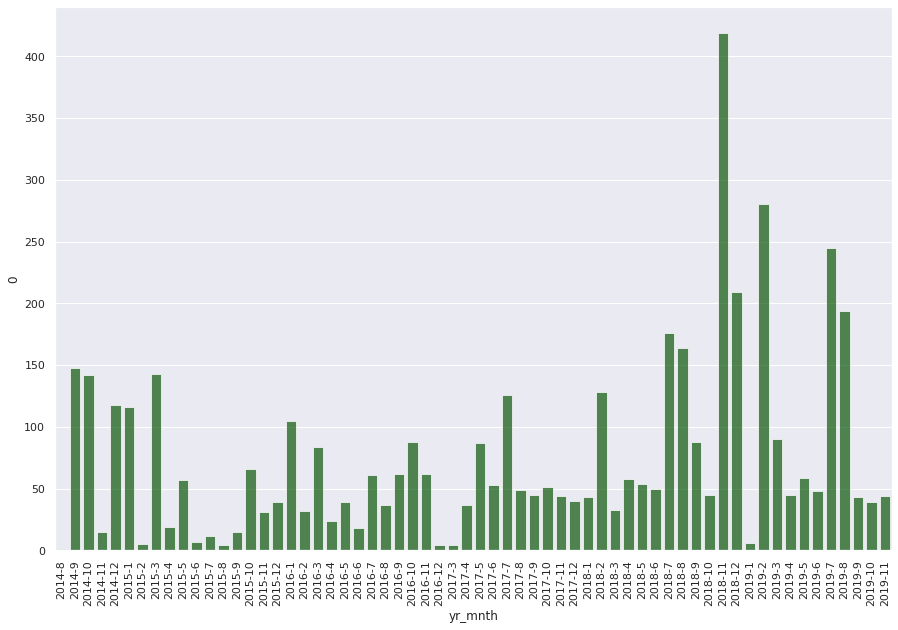

In [12]:
# Plttting the summary for a rough visual idea of my travel history to unique places every month 
plt.figure(figsize=(15, 10))
ax = sns.barplot(x=df_summary.yr_mnth, y=df_summary.iloc[:, 2], data=df_summary,  color = 'darkgreen', alpha=0.7)
plt.xticks(rotation=90)
plt.show()

Oh noes! It looks like he may be right at first glance :( I'm still going to try to find a switchpoint statistically because I am working through the textbook here https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers and this is a great opportunity to try out the PyMC3 package. 

The counts of places visited every month can be modelled as a Poisson distribution. For the prior, *tau* is the the switchpoint which could've have occurred at any point from Month 1 to Month 62.  

In [13]:
with pm.Model() as model:
    alpha = 1.0 / df_summary.iloc[:, 2].mean()  
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=61) 

with model:
    idx = np.arange(62) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2) 
    
with model:
    observation = pm.Poisson("obs", lambda_, observed=df_summary.iloc[:, 2]) 
    


In [14]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

    
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau'] 

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:09<00:00, 3223.96draws/s]
The number of effective samples is smaller than 25% for some parameters.


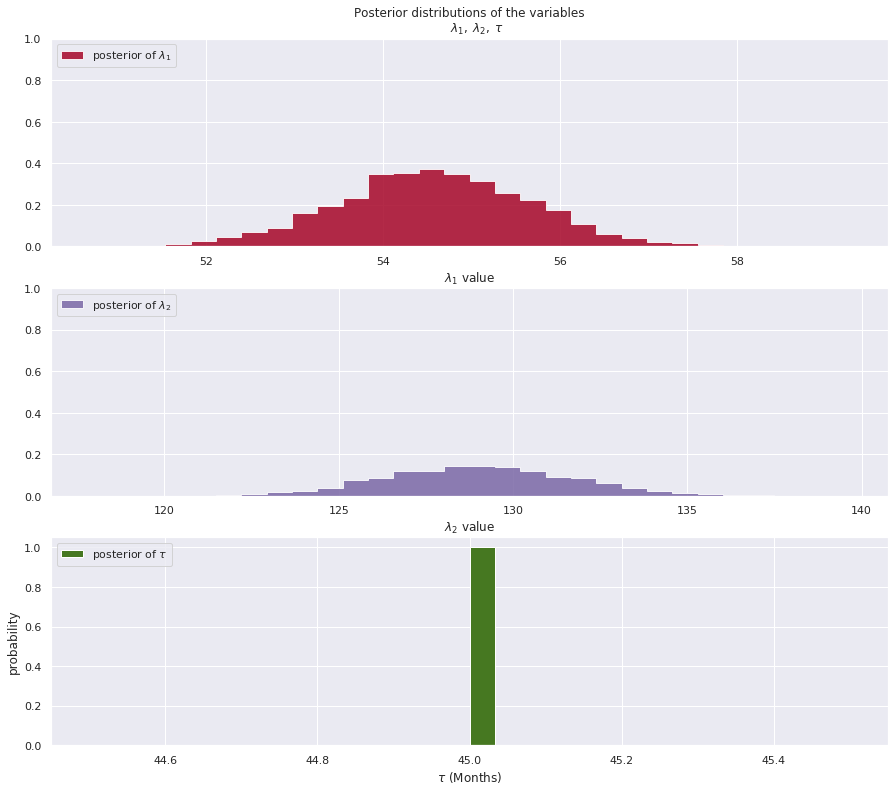

In [15]:
figsize(15, 13)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=30, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)

plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (Months)")
plt.ylabel("probability")
plt.show()

The *lambdas* are fairly different can can be seen from visual inspection of the trace plots. The switch itself appears to have occurred at around Month 45 which is July-2018 which is right before the time we got married as my husband gleefully reminded me. 

No handles with labels found to put in legend.


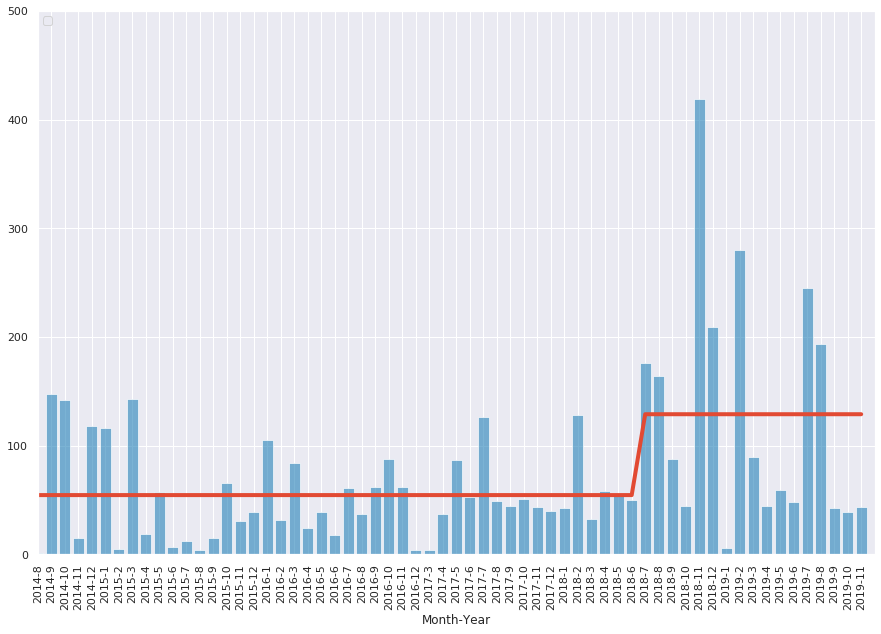

In [40]:

figsize(15, 10)

N = tau_samples.shape[0]
expected_trips = np.zeros(62)
for day in range(0, 62):
    ix = day < tau_samples
    expected_trips[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(62), expected_trips,  lw=4, color="#E24A33")
plt.xlim(0, 62)
plt.xlabel("Month-Year") 
plt.xticks(df_summary.index,df_summary["yr_mnth"].values, rotation=90)

plt.ylim(0, 500)
plt.bar(np.arange(len(df_summary.iloc[:, 2])), df_summary.iloc[:, 2], color="#348ABD", alpha=0.65)

plt.legend(loc="upper left");

So he won. Whatever. 

## References: 
1. https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb 